In [64]:
from heisembergs import sparse_xxz_hamiltonian
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.special import gamma
from scipy.optimize import curve_fit
import numpy as np
import os

### Antiferromagnetic XXZ model

#### Analytical-numerical comparison of the maximum probability

In [65]:
def get_max_gs_amplitude_cbasis(sparse_hamiltonian):
    """Returns the maximum amplitude of the ground state of the given Hamiltonian and the corresponding index in the computational basis"""
    evals, evecs = sparse.linalg.eigsh(sparse_hamiltonian, which="SA", k=1, tol=1e-8)
    amps = (np.conj(evecs[:, 0]) * evecs[:, 0]).real
    max_amp_ind = np.argmax(amps)
    max_amp = amps[max_amp_ind]
    tinvariant_amplitudes = amps[np.isclose(amps, max_amp)]
    max_amp_tinvariant = np.sum(tinvariant_amplitudes)
    return max_amp_ind, max_amp

def analytical_log_max_amp(N):
    # return (N-1)*np.log(3*np.sqrt(3)/4) + 2*np.log(np.sqrt(np.pi)/gamma(2/3)) + 2*np.log(gamma(N/2 + 1/6)/gamma(N/2)) # Exact expression
    return (N-1)*np.log(3*np.sqrt(3)/4) + 2*np.log(np.sqrt(np.pi)/gamma(2/3)) + np.log(N/2)/3 # Stirling formula approximation

def analytical_log_max_amp_correction(N):
    return np.log(N/2)/3

In [66]:
def get_max_amp_Nrange(N_odd_range, antiferro, delta):
    filename = f"Results/max_amplitudes_xxz_model_N_{N_odd_range[0]}_{N_odd_range[1]}_antiferro_{antiferro}_delta_{delta:.04f}.txt"

    if not os.path.exists(filename):
        N_arr = np.arange(N_odd_range[0] if N_odd_range[0] % 2 else N_odd_range[0] - 1,
                        N_odd_range[1] + 1 if N_odd_range[1] % 2 else N_odd_range[0] + 1,
                        2)

        max_amp_indices = np.zeros_like(N_arr)
        max_amp_arr = np.zeros_like(N_arr, dtype=float)

        for i, N in enumerate(N_arr):
            print(f"\rN = {N}", end="")
            H = sparse_xxz_hamiltonian(delta, antiferro, N)
            max_amp_index, max_amp = get_max_gs_amplitude_cbasis(H)
            max_amp_indices[i] = max_amp_index
            max_amp_arr[i] = max_amp
        
        filedata = np.zeros((len(N_arr), 3))
        filedata[:, 0] = N_arr
        filedata[:, 1] = max_amp_arr
        filedata[:, 2] = max_amp_indices
        np.savetxt(filename, filedata)
    else:
        filedata = np.loadtxt(filename)
        N_arr = filedata[:, 0].astype(int)
        max_amp_arr = filedata[:, 1]
        max_amp_indices = filedata[:, 2].astype(int)

    return N_arr, max_amp_arr, max_amp_indices

In [67]:
N_odd_range = [9, 21]
antiferro = False
delta = 0

N_arr, max_amp_arr, max_amp_indices = get_max_amp_Nrange(N_odd_range, antiferro, delta)


Basis state with the maximum amplitude
N = 9: |101010010> = |338>
N = 11: |01010101010> = |682>
N = 13: |0101010100101> = |2725>
N = 15: |010101010100101> = |10917>
N = 17: |01001010101010101> = |38229>
N = 19: |0101010101010010101> = |174741>
N = 21: |101010101010101010100> = |1398100>



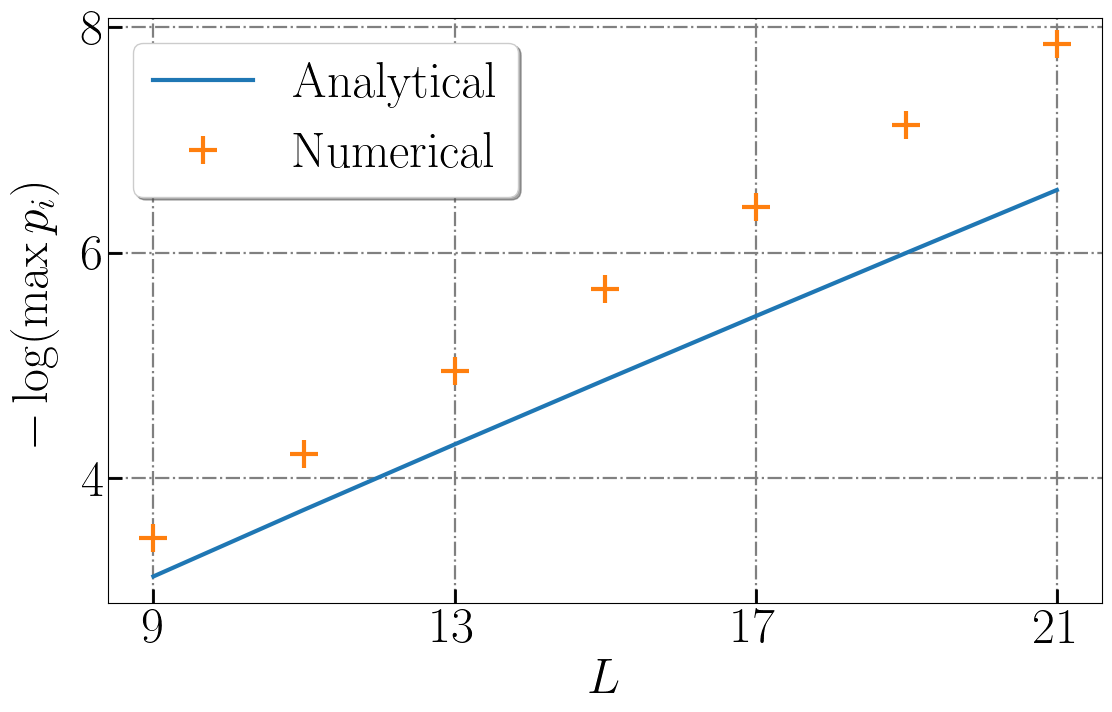

In [68]:
header_string = "".join(["Basis state with the maximum amplitude\n"] + [f"N = {N}: |{int(index):0{N}b}> = |{index}>\n" for N, index in zip(N_arr, max_amp_indices)])
print(f"\n{header_string}")

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{physics} \usepackage{mathtools}")
plt.rc("font", family="serif", size=36, weight="bold")
fig, ax = plt.subplots(1, 1, figsize=[12, 8])

plt.plot(N_arr, analytical_log_max_amp(N_arr), linewidth=3, label="Analytical")
plt.plot(N_arr, -np.log(max_amp_arr), "+", markersize=20, markeredgewidth=3, label="Numerical")

plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tick_params(width=2, length=10, direction="in")
plt.xlabel("$L$")
plt.ylabel(r"$-\log (\max p_i)$", labelpad=15)
plt.xticks(np.arange(N_arr[0], N_arr[-1] + 1, 4))
plt.tight_layout()
plt.legend(shadow=True)
plt.savefig(f"Max_pi_entropy_scaling_xxz_model_N_{N_odd_range[0]}_{N_odd_range[1]}_antiferro_{antiferro}_delta_{delta:.04f}.png", dpi=300)

#### Only logarithmic correction + numerical fit

In [69]:
def to_fit_log_correction(N, ccharge, Nfactor):
    return ccharge*np.log(N*Nfactor)

initials = [0.1, 0.1]
bounds = ((0, 0), (np.inf, np.inf))

# Non-linear least squares to fit also for the argument
isolated_num_log_corr = -np.log(max_amp_arr) - (N_arr-1)*np.log(3*np.sqrt(3)/4) - 2*np.log(np.sqrt(np.pi)/gamma(2/3))
regression = curve_fit(to_fit_log_correction, N_arr, isolated_num_log_corr, p0=initials, bounds=bounds)
popt = regression[0]
errors = np.sqrt(np.diag(regression[1]))

print("Logarithmic correction to the entanglement entropy fit result\n")
print("Fit function: a log(N*b)")
print(f"a = {popt[0]} ± {errors[0]}")
print(f"b = {popt[1]} ± {errors[1]}")

Logarithmic correction to the entanglement entropy fit result

Fit function: a log(N*b)
a = 1.4531484884470727 ± 0.06545402863945753
b = 0.19037443594026185 ± 0.009000016184248318


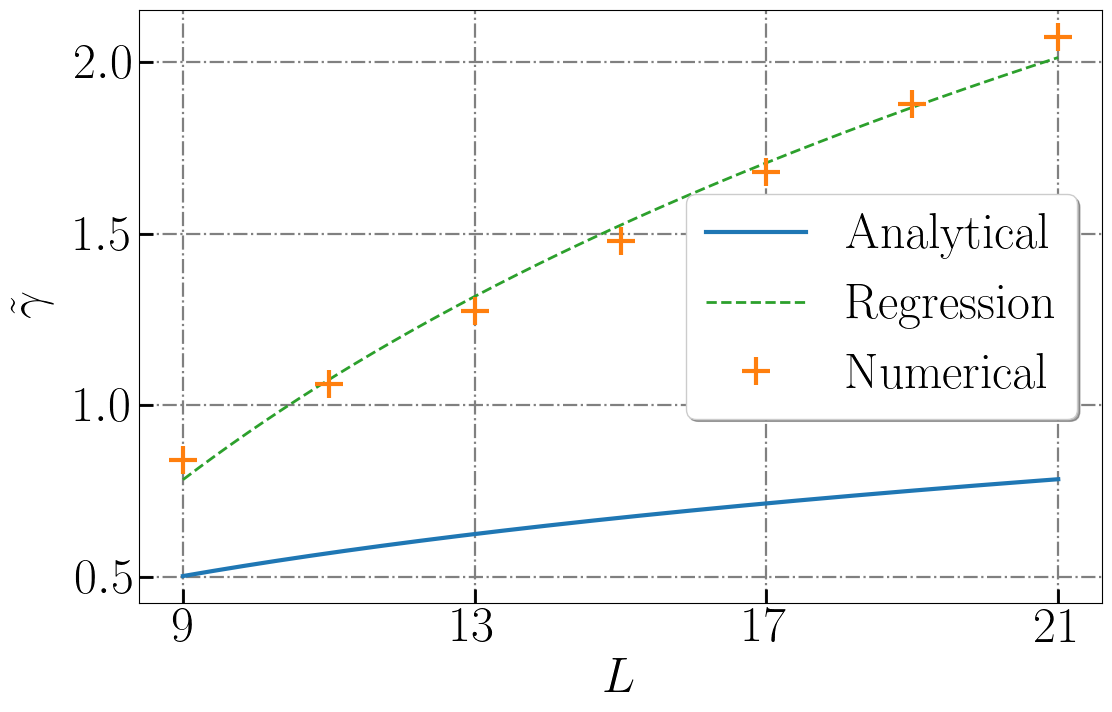

In [70]:
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{physics} \usepackage{mathtools}")
plt.rc("font", family="serif", size=36, weight="bold")
fig, ax = plt.subplots(1, 1, figsize=[12, 8])

smooth_N_arr = np.linspace(N_odd_range[0], N_odd_range[1], 1000)

plt.plot(smooth_N_arr, analytical_log_max_amp_correction(smooth_N_arr), "-", color="tab:blue", linewidth=3, label="Analytical")
plt.plot(smooth_N_arr, to_fit_log_correction(smooth_N_arr, *popt), "--", color="tab:green", linewidth=2, label="Regression")
plt.plot(N_arr, isolated_num_log_corr, "+", color="tab:orange", markersize=20, markeredgewidth=3, label="Numerical")

plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tick_params(width=2, length=10, direction="in")
plt.xlabel("$L$")
plt.ylabel(r"$\tilde{\gamma}$", labelpad=15)
plt.xticks(np.arange(N_arr[0], N_arr[-1] + 1, 4))
plt.tight_layout()
plt.legend(shadow=True)

<span style="color:red">FOR THE REGRESSION TO BE CORRECT WE NEED TO GO TO LARGER SIZES, SO THAT THE CONTRIBUTION COMING FROM THE CENTRAL CHARGE TERM IS WELL DEFINED AND IT CAN BE ISOLATED</span>

#### $\infty$-Rènyi entropy fit

Expected scaling: $S = \alpha L + \beta \log L + \gamma$

In [71]:
def to_fit_renyi_inf(N, alpha, beta, gamma):
    return alpha*N + beta*np.log(N) + gamma

initials = [0.1, 0.1, 0.1]

regression = curve_fit(to_fit_renyi_inf, N_arr, -np.log(max_amp_arr), p0=initials)
popt = regression[0]
errors = np.sqrt(np.diag(regression[1]))

print("∞-Rènyi entropy fit result\n")
print("Fit function: ɑ L + β log L + Ɣ")
print(f"ɑ = {popt[0]} ± {errors[0]}")
print(f"β = {popt[1]} ± {errors[1]}")
print(f"Ɣ = {popt[2]} ± {errors[2]}")

∞-Rènyi entropy fit result

Fit function: ɑ L + β log L + Ɣ
ɑ = 0.3462528401256255 ± 3.500171320317211e-05
β = 0.25688309554576577 ± 0.0004984540197141585
Ɣ = -0.2089755075942051 ± 0.0008124377500522559


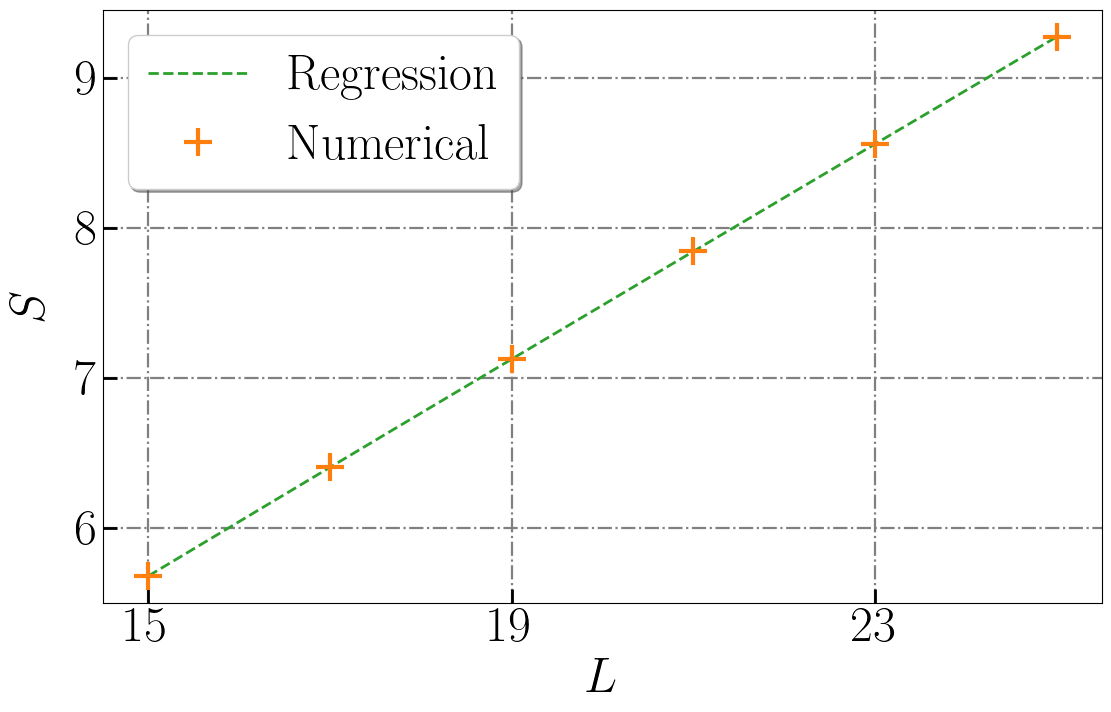

In [43]:
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{physics} \usepackage{mathtools}")
plt.rc("font", family="serif", size=36, weight="bold")
fig, ax = plt.subplots(1, 1, figsize=[12, 8])

smooth_N_arr = np.linspace(N_odd_range[0], N_odd_range[1], 1000)

plt.plot(smooth_N_arr, to_fit_renyi_inf(smooth_N_arr, *popt), "--", color="tab:green", linewidth=2, label="Regression")
plt.plot(N_arr, -np.log(max_amp_arr), "+", color="tab:orange", markersize=20, markeredgewidth=3, label="Numerical")

plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tick_params(width=2, length=10, direction="in")
plt.xlabel("$L$")
plt.ylabel(r"$S$", labelpad=15)
plt.xticks(np.arange(N_arr[0], N_arr[-1] + 1, 4))
plt.tight_layout()
plt.legend(shadow=True)

#### Fits for different $\Delta$

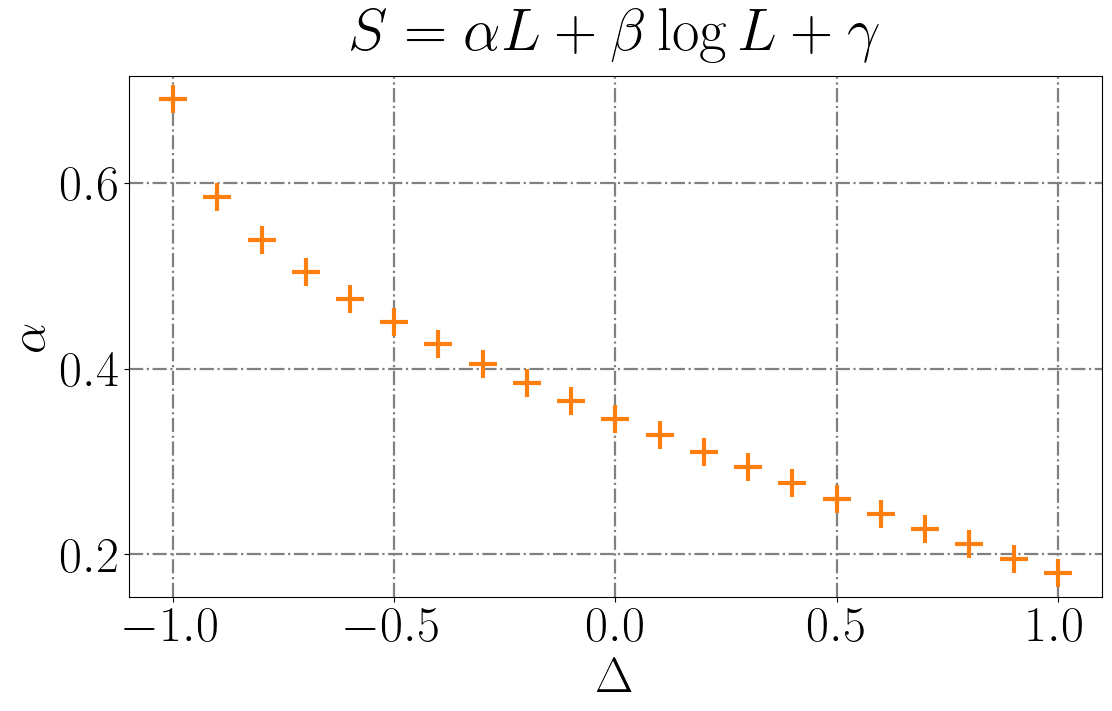

In [76]:
N_odd_range = [9, 21]
antiferro = False
delta_arr = np.linspace(-1, 1, 21)
fit_initials = [0.1, 0.1, 0.1]

params_arr = []
params_err_arr = []

for delta in delta_arr:
    N_arr, max_amp_arr, max_amp_indices = get_max_amp_Nrange(N_odd_range, antiferro, delta)
    regression = curve_fit(to_fit_renyi_inf, N_arr, -np.log(max_amp_arr), p0=initials)
    popt = regression[0]
    errors = np.sqrt(np.diag(regression[1]))
    params_arr.append(popt)
    params_err_arr.append(errors)

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{physics} \usepackage{mathtools}")
plt.rc("font", family="serif", size=36, weight="bold")
fig, ax = plt.subplots(1, 1, figsize=[12, 8])

plt.plot(delta_arr, [popt[0] for popt in params_arr], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$\alpha$")
plt.title(r"$S = \alpha L + \beta \log L + \gamma$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
plt.savefig(f"alpha_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

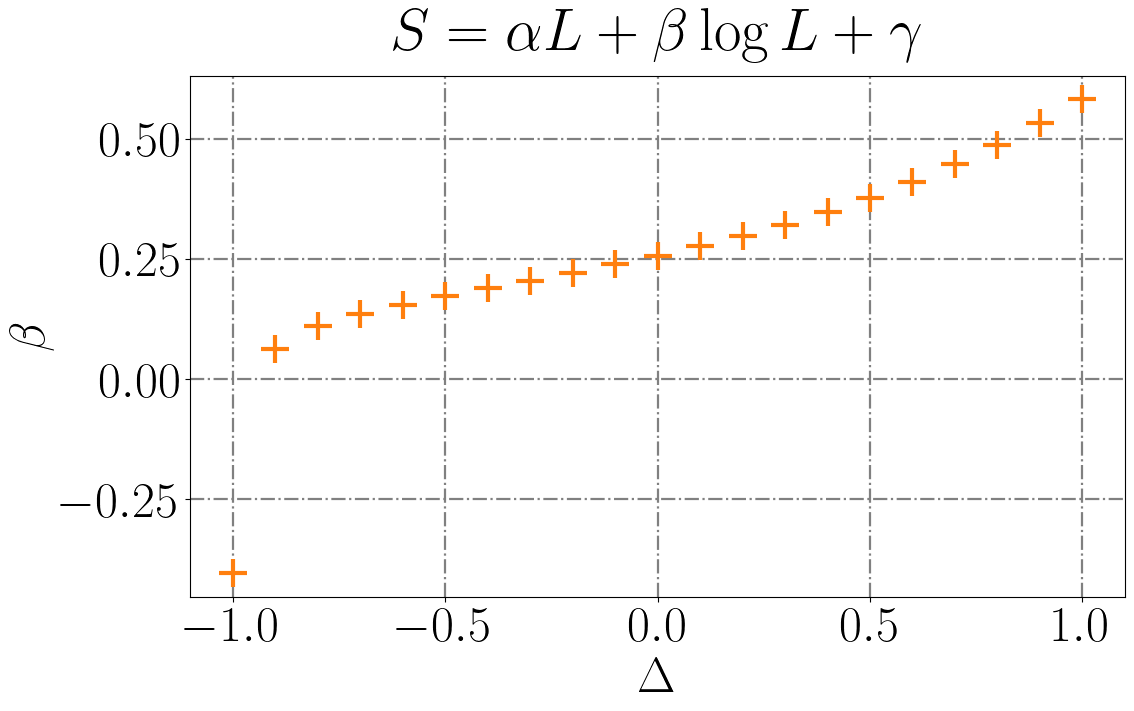

In [72]:
N_odd_range = [9, 21]
antiferro = False
delta_arr = np.linspace(-1, 1, 21)
fit_initials = [0.1, 0.1, 0.1]

params_arr = []
params_err_arr = []

for delta in delta_arr:
    N_arr, max_amp_arr, max_amp_indices = get_max_amp_Nrange(N_odd_range, antiferro, delta)
    regression = curve_fit(to_fit_renyi_inf, N_arr, -np.log(max_amp_arr), p0=initials)
    popt = regression[0]
    errors = np.sqrt(np.diag(regression[1]))
    params_arr.append(popt)
    params_err_arr.append(errors)

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{physics} \usepackage{mathtools}")
plt.rc("font", family="serif", size=36, weight="bold")
fig, ax = plt.subplots(1, 1, figsize=[12, 8])

plt.plot(delta_arr, [popt[1] for popt in params_arr], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$\beta$")
plt.title(r"$S = \alpha L + \beta \log L + \gamma$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
plt.savefig(f"beta_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

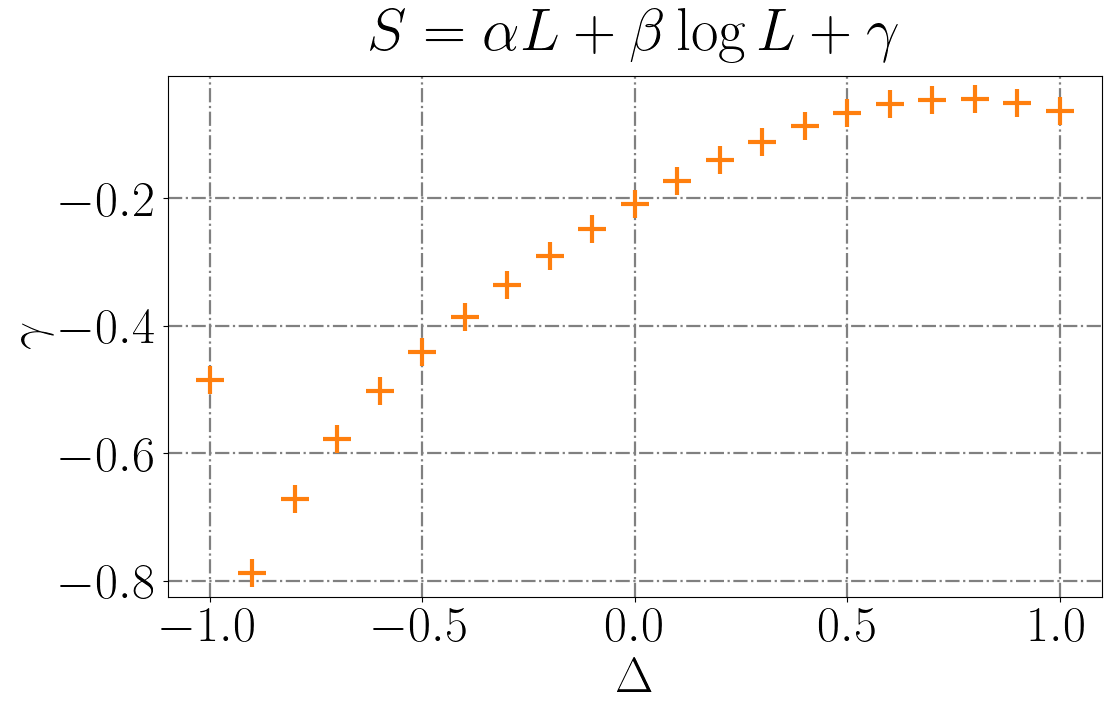

In [75]:
N_odd_range = [9, 21]
antiferro = False
delta_arr = np.linspace(-1, 1, 21)
fit_initials = [0.1, 0.1, 0.1]

params_arr = []
params_err_arr = []

for delta in delta_arr:
    N_arr, max_amp_arr, max_amp_indices = get_max_amp_Nrange(N_odd_range, antiferro, delta)
    regression = curve_fit(to_fit_renyi_inf, N_arr, -np.log(max_amp_arr), p0=initials)
    popt = regression[0]
    errors = np.sqrt(np.diag(regression[1]))
    params_arr.append(popt)
    params_err_arr.append(errors)

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{physics} \usepackage{mathtools}")
plt.rc("font", family="serif", size=36, weight="bold")
fig, ax = plt.subplots(1, 1, figsize=[12, 8])

plt.plot(delta_arr, [popt[2] for popt in params_arr], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$\gamma$")
plt.title(r"$S = \alpha L + \beta \log L + \gamma$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
plt.savefig(f"gamma_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

In [9]:
# import pandas as pd

# data = np.zeros((len(delta_arr), 4))
# data[:, 0] = delta_arr
# data[:, 1] = np.array([popt[0] for popt in params_arr])
# data[:, 2] = np.array([popt[1] for popt in params_arr])
# data[:, 3] = np.array([popt[2] for popt in params_arr])

# df = pd.DataFrame(data, columns=["Δ", "ɑ", "β", "Ɣ"])
# with open("nice_data_table.html", "w") as f:
#     f.write(df.to_html())

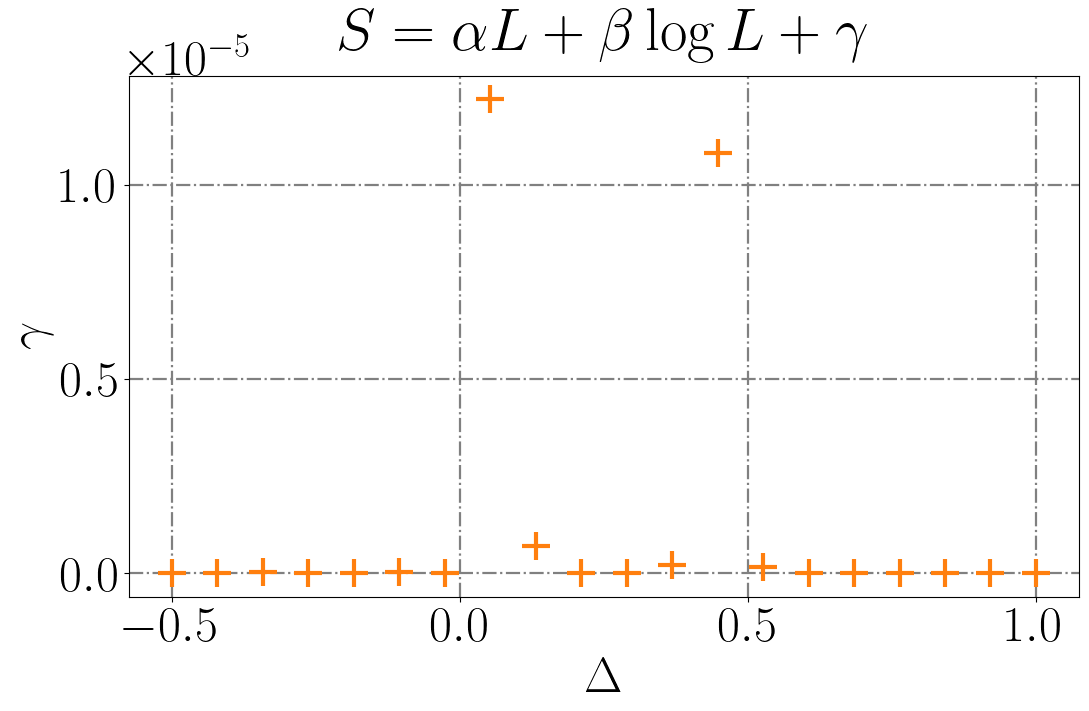

In [11]:
N_odd_range = [9, 21]
antiferro = False
delta_arr = np.linspace(-1/2, 1, 20) #[-1, -1/2, 0, 1/2, 1]
fit_initials = [0.1, 0.1, 0.1]
fit_bounds = ((0, 0, 0), (np.inf, np.inf, np.inf))

params_arr = []
params_err_arr = []

for delta in delta_arr:
    N_arr, max_amp_arr, max_amp_indices = get_max_amp_Nrange(N_odd_range, antiferro, delta)
    regression = curve_fit(to_fit_renyi_inf, N_arr, -np.log(max_amp_arr), p0=initials, bounds=bounds)
    popt = regression[0]
    errors = np.sqrt(np.diag(regression[1]))
    params_arr.append(popt)
    params_err_arr.append(errors)

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{physics} \usepackage{mathtools}")
plt.rc("font", family="serif", size=36, weight="bold")
fig, ax = plt.subplots(1, 1, figsize=[12, 8])

plt.plot(delta_arr, [popt[2] for popt in params_arr], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$\gamma$")
plt.title(r"$S = \alpha L + \beta \log L + \gamma$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
plt.savefig(f"beta_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

### Complete Shannon entropy

In [11]:
def get_gs_shannon_entropy(sparse_hamiltonian):
    evals, evecs = sparse.linalg.eigsh(sparse_hamiltonian, which="SA", k=1)
    probs = np.abs(evecs[:, 0])**2
    return np.sum(-probs*np.log(probs))

In [12]:
N_odd_range = [15, 25]
antiferro = False
delta = 1/2

filename_shannon = f"Results/shannon_xxz_model_N_{N_odd_range[0]}_{N_odd_range[1]}_antiferro_{antiferro}_delta_{delta:.04f}.txt"

N_arr = np.arange(N_odd_range[0] if N_odd_range[0] % 2 else N_odd_range[0] - 1,
                  N_odd_range[1] + 1 if N_odd_range[1] % 2 else N_odd_range[0] + 1,
                  2)

if not os.path.exists(filename_shannon):
    shannon_entroy_arr = np.zeros_like(N_arr)
    for i, N in enumerate(N_arr):
        print(f"\rN = {N}", end="")
        H = sparse_xxz_hamiltonian(delta, antiferro, N)
        shannon_entroy_arr[i] = get_gs_shannon_entropy(H)
else:
    filedata = np.loadtxt(filename_shannon)
    shannon_entroy_arr = filedata[:, 1]

N = 21

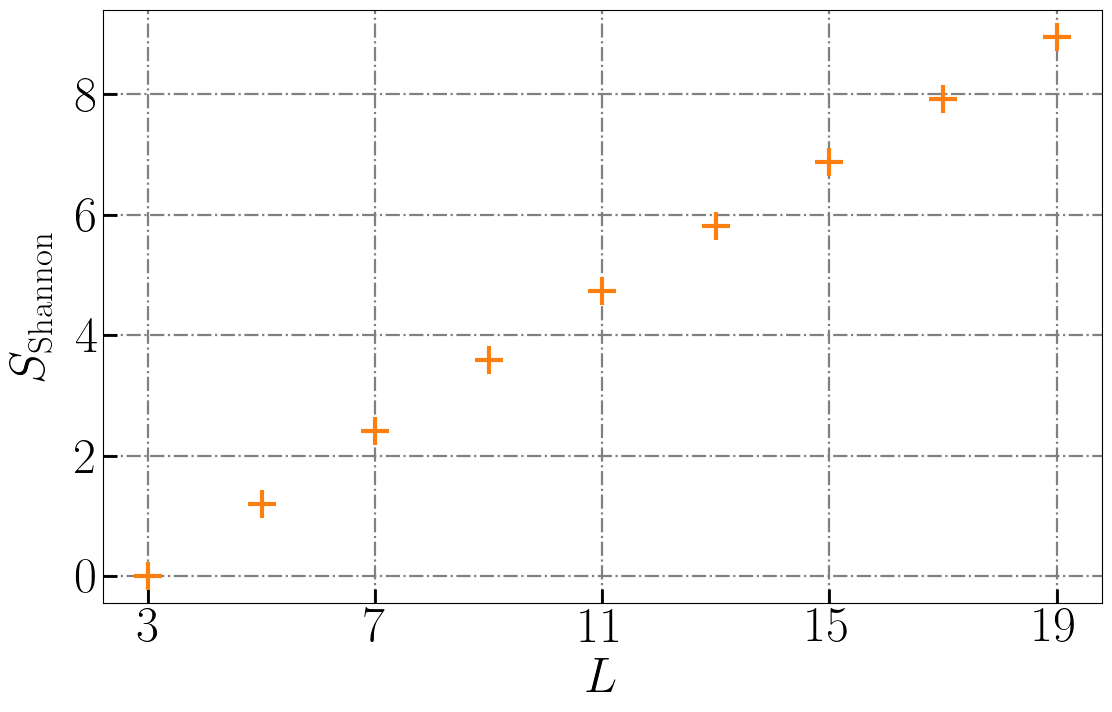

In [ ]:
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{physics} \usepackage{mathtools}")
plt.rc("font", family="serif", size=36, weight="bold")
fig, ax = plt.subplots(1, 1, figsize=[12, 8])

plt.plot(N_arr, shannon_entroy_arr - max_amp_arr*N_arr, "+", color="tab:orange", markersize=20, markeredgewidth=3, label="Numerical")

plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tick_params(width=2, length=10, direction="in")
plt.xlabel("$L$")
plt.ylabel(r"$S_{\mathrm{Shannon}}$", labelpad=15)
plt.xticks(np.arange(N_arr[0], N_arr[-1] + 1, 4))
plt.tight_layout()
# plt.legend(shadow=True)